In [603]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [1]:
df = pd.read_csv("data/no1_train.csv")
df_validation = pd.read_csv("data/no1_validation.csv")

NameError: name 'pd' is not defined

In [ ]:
df.columns, df.shape

In [ ]:
df_validation.columns, df_validation.shape

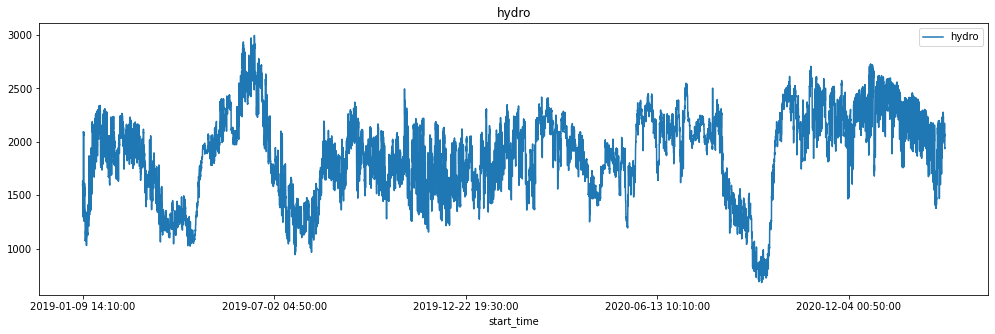

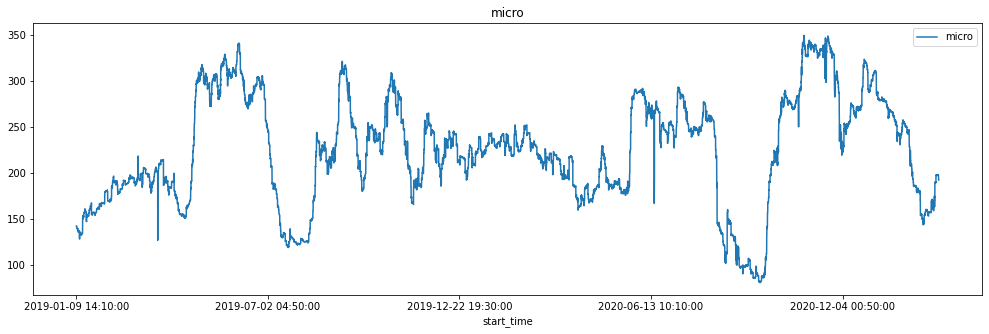

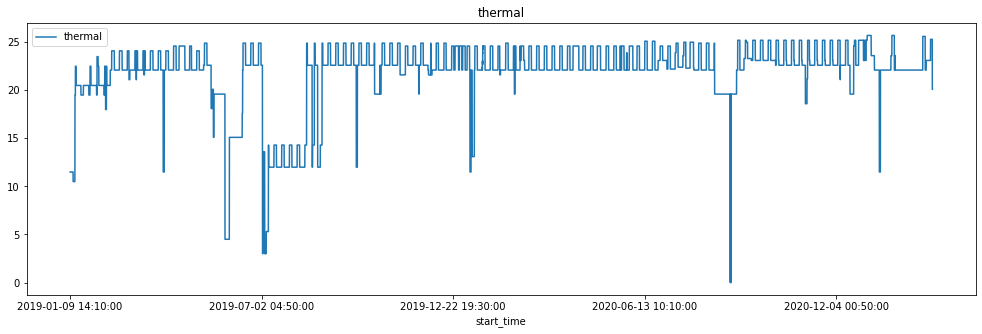

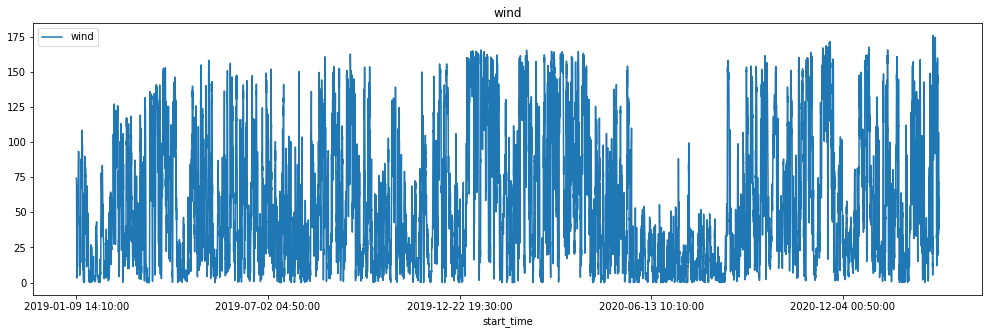

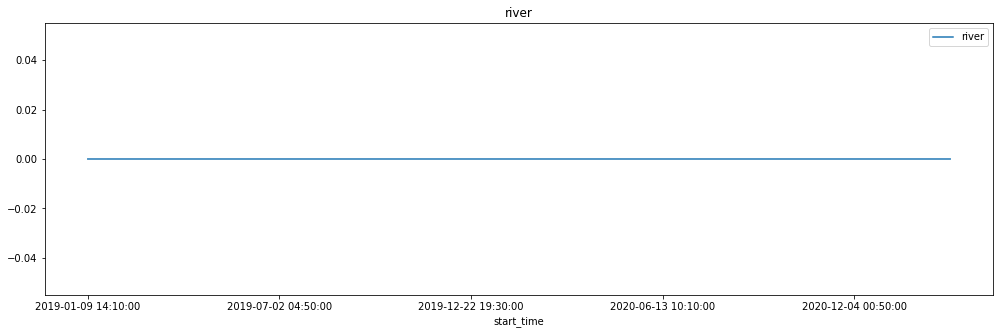

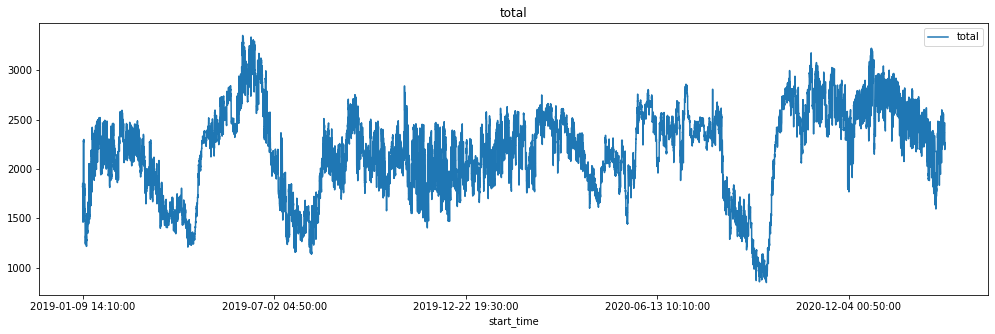

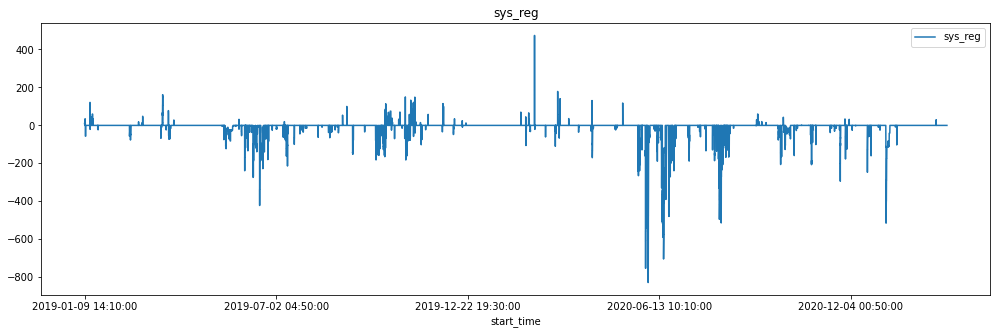

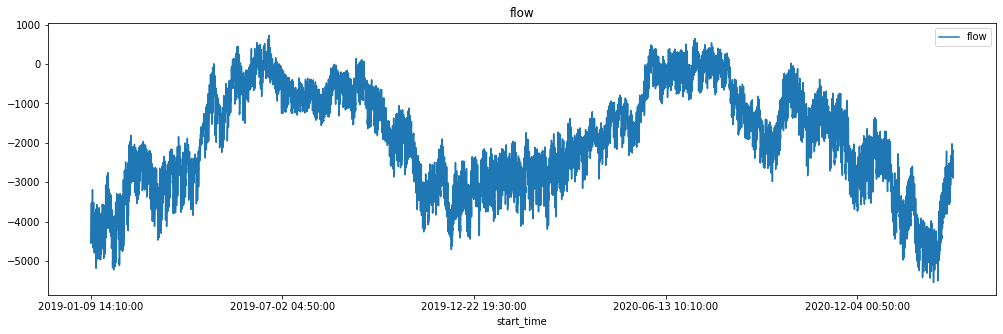

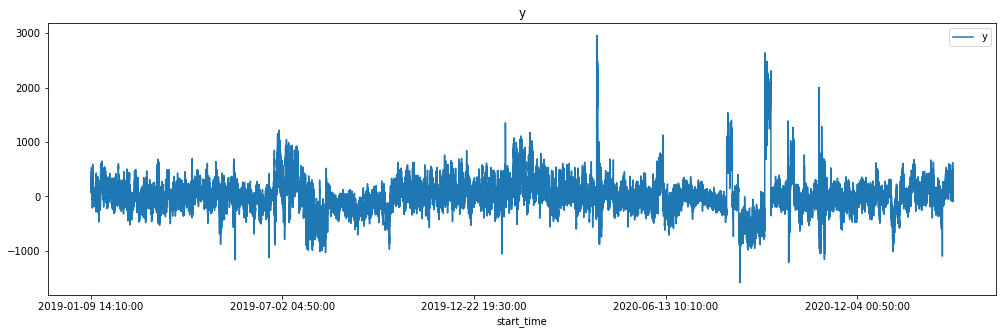

In [607]:
cols = ['hydro', 'micro', 'thermal', 'wind', 'river', 'total', 'sys_reg', 'flow', 'y']
#df_validation['start_time'] = pd.to_datetime(df_validation['start_time'])
for col in cols:
    df.plot(x="start_time", y=col ,figsize=(17,5), title=col)
    plt.show()

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hydro,225088.0,1888.334127,401.000305,683.438000,1625.0290,1933.916000,2175.595000,2995.524000
micro,225088.0,224.189826,58.559855,80.371000,185.0170,225.938000,269.558000,349.271000
thermal,225088.0,21.803497,3.579229,0.000000,22.1000,22.100000,24.100000,25.700000
wind,225088.0,55.703266,47.053033,0.000000,15.7040,41.848000,88.723000,176.000000
river,225088.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
total,225088.0,2190.031963,444.077730,849.732000,1916.5230,2248.874000,2497.792000,3351.974000
y,225088.0,8.907921,320.262539,-1579.680903,-142.2267,-11.282351,127.454943,2956.333317
sys_reg,225088.0,-8.284305,43.748315,-828.000000,0.0000,0.000000,0.000000,474.000000
flow,225088.0,-1999.055081,1311.682286,-5541.200000,-2996.7000,-1953.700000,-906.900000,723.400000


## Feature exploration

In [7]:
df['start_time'] = pd.to_datetime(df['start_time'])
fft = tf.signal.rfft(df.flow.values)
fft_abs = np.abs(fft)
fft_abs.max()

450299070.0

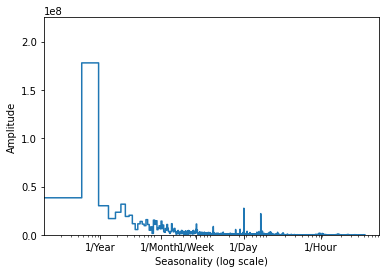

In [8]:
n_samples_five_mins = df.shape[0]

n_samples_clock_quarters = n_samples_five_mins / 4 # how many samples per clock quarter
n_samples_hours = n_samples_five_mins / 12 # how many hours in the dataset
n_samples_days =  n_samples_hours / 24 # how many days in the dataset
n_samples_weeks = n_samples_days / 7 # how many weeks in the dataset
n_samples_months = n_samples_days / 30 # how many months in the dataset
n_samples_years = n_samples_days / 365 # how many years in the dataset

five_mins_per_year = 12*24*365.2524 # how many 5-min samples per week
years_per_dataset = n_samples_five_mins / five_mins_per_year # how many weeks in the dataset

f_per_year = np.arange(0, len(fft)) / years_per_dataset

plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, max(np.abs(fft)/2))
plt.ylabel('Amplitude')
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1,  12 , 52, 365.2524, 365.2524*24 ], labels=['1/Year', '1/Month', '1/Week', '1/Day','1/Hour'])
_ = plt.xlabel('Seasonality (log scale)')

plt.show()

In [608]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))
xcov_hour = [crosscorr(df.hydro, df.hydro, lag=i) for i in range(12*24*7)]

Text(0.5, 0, 'Lag (days)')

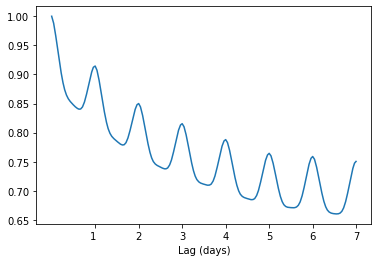

In [609]:
plt.plot(xcov_hour)
plt.xticks(np.arange(1,8,1) * 12*24, labels=['1 ', '2', '3', '4','5','6','7'])
plt.xlabel('Lag (days)')

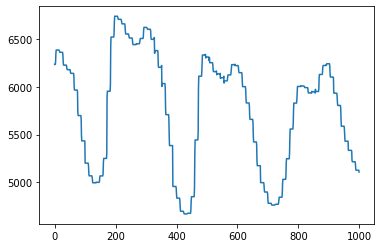

In [602]:
structural_imbalance = (df.total - df.flow).values[:1000]
plt.plot(structural_imbalance)

## Data cleaning

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hydro,225088.0,1888.334127,401.000305,683.438000,1625.0290,1933.916000,2175.595000,2995.524000
micro,225088.0,224.189826,58.559855,80.371000,185.0170,225.938000,269.558000,349.271000
thermal,225088.0,21.803497,3.579229,0.000000,22.1000,22.100000,24.100000,25.700000
wind,225088.0,55.703266,47.053033,0.000000,15.7040,41.848000,88.723000,176.000000
river,225088.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
total,225088.0,2190.031963,444.077730,849.732000,1916.5230,2248.874000,2497.792000,3351.974000
y,225088.0,8.907921,320.262539,-1579.680903,-142.2267,-11.282351,127.454943,2956.333317
sys_reg,225088.0,-8.284305,43.748315,-828.000000,0.0000,0.000000,0.000000,474.000000
flow,225088.0,-1999.055081,1311.682286,-5541.200000,-2996.7000,-1953.700000,-906.900000,723.400000


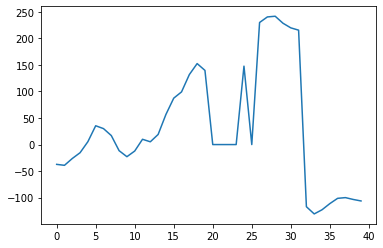

In [95]:
noisy_data = df_validation.y[18635-20:18635+20]
noisy_data[noisy_data < -700] = np.nan
plt.plot(noisy_data)

In [313]:
df = pd.read_csv("data/no1_train.csv")
df_validation = pd.read_csv("data/no1_validation.csv")
df_validation_copy = df_validation.copy(deep=True)
df_validation_copy["y"].where(df_validation_copy.y > -700, 0, inplace=True)

df.y.mean(), df_validation.y.mean(), np.concatenate((df_validation.y.values, df.y.values)).mean(), df_validation_copy.y.mean()

(8.907921267636192, -20.07891541243429, 5.68716163651725, 16.479701188523972)

In [207]:
df.columns

Index(['start_time', 'hydro', 'micro', 'thermal', 'wind', 'river', 'total',
       'y', 'sys_reg', 'flow'],
      dtype='object')

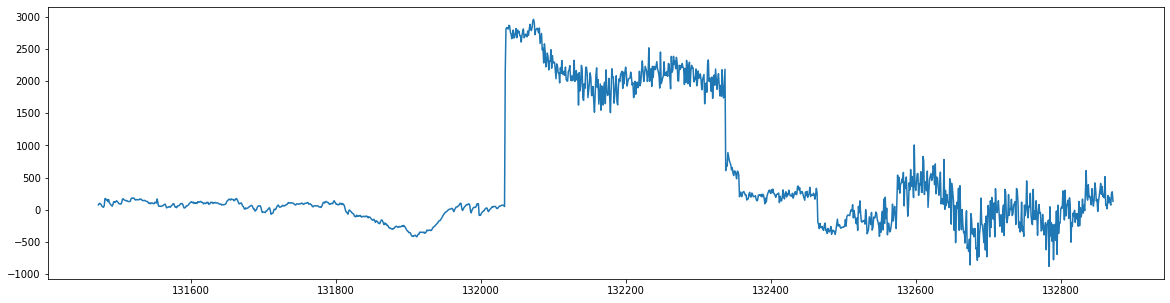

In [365]:
strange_idx = df.y.argmax()
plt.figure(figsize=(20,5))
df.y[strange_idx-600:strange_idx+800].plot()
plt.show()


In [ ]:
for col in df.columns[1:-1]:
	df_cop = df[["start_time", col]].iloc[strange_idx-200:strange_idx+200]
	df_cop.plot(x="start_time", y=col, figsize=(20,5), title=col)
	plt.show()

In [ ]:
df_cop.plot(x="start_time", y="y", figsize=(17,5))

In [292]:
y_train_mean = df.y.mean()
y_validation_mean = df_validation.y.mean()
y_train_std = df.y.std()
y_validation_std = df_validation.y.std()

y_validation_cleaned_mean = df_validation_copy.y.mean()
y_validation_cleaned_std = df_validation_copy.y.std()

# TRAIN DATA
## How the different means and std's affect the data cleaning.
df.y[np.abs(df.y.values) >  y_train_mean      + 4*y_train_std].count() / df.shape[0]

0.008374502416832528

In [296]:
df_validation.y.median()

30.963341657552366

In [307]:
# VALIDATION DATA
## How the different means and std's affect the data cleaning. Think I will use y_train_mean and y_train_std to clean the validation set
df_validation.y[np.abs(df_validation.y.values) >  y_train_mean      + 2.4*y_train_std].count() / df_validation.shape[0], \
df_validation.y[np.abs(df_validation.y.values) >  y_validation_mean + 3*y_validation_std].count() / df_validation.shape[0], \
df_validation.y[np.abs(df_validation.y.values) >  y_validation_cleaned_mean + 10*y_validation_cleaned_std].count() / df_validation.shape[0], \
df_validation.y[np.abs(df_validation.y.values) >  df_validation.y.median() + 4*df_validation.y.mad()].count() / df_validation.shape[0]

(0.01105345464884845,
 0.0071083309638896785,
 0.010804663065112312,
 0.011124537958487347)

<AxesSubplot:ylabel='Frequency'>

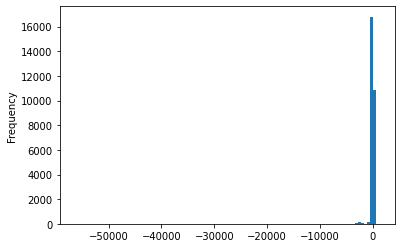

In [314]:
df_validation.y.plot(kind="hist", bins=100)

-56379.459762941435 1223.8083715598814
Threshold: 706.494. Removed spiky data. Percent removed: 1.1125% 


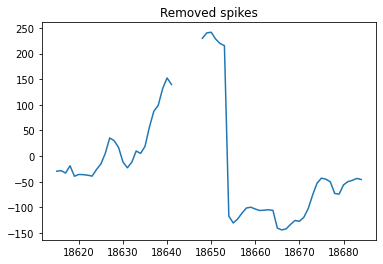

-705.6361829119612 578.581378865477


Text(0.5, 1.0, 'Interpolated')

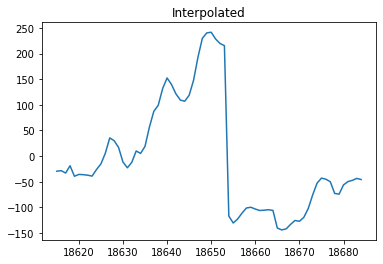

In [332]:
df_validation = pd.read_csv("data/no1_validation.csv")
print(df_validation.y.min(), df_validation.y.max())
threshold = df_validation.y.median() + 4*df_validation.y.mad()
print("Threshold: %.3f. Removed spiky data. Percent removed: %.4f%% " % (threshold, 100 * df_validation.y[np.abs(df_validation.y.values) > threshold].count() / df_validation.shape[0]))

df_validation_copy = df_validation.copy(deep=True)
df_validation_copy["y"].where(np.abs(df_validation.y.values) < threshold, np.nan, inplace=True)
plt.plot(df_validation_copy["y"][18635-20:18635+50]) # The critical part of y data
plt.title("Removed spikes")
plt.show()
print(df_validation_copy.y.min(), df_validation_copy.y.max())
df_validation_copy["y"].interpolate(method='cubic', inplace=True)
plt.plot(df_validation_copy["y"][18635-20:18635+50])
plt.title("Interpolated")

In [546]:
from tqdm import tqdm
def hample_filter(raw_signal, window_size=10, sigma=3):
	"""
	Apply a Hampel filter to a signal.
	:returns: filtered signal
	"""
	signal = np.asarray(raw_signal)
	signal_len = len(signal)
	num_fixed = 0
	for i in tqdm(range(window_size, signal_len - window_size)):
		window = signal[i - window_size:i + window_size]
		median = np.median(window)
		mad = np.median(np.abs(window - median))

		if np.abs(signal[i]) > median + sigma * mad:
			signal[i] = np.nan
			num_fixed += 1
	print("Corrected %.2f%%" % (100 * num_fixed/signal_len) )
	return signal

In [547]:
df_validation = pd.read_csv("data/no1_validation.csv")
df_min = df_validation.y.argmin()
#correced_y = hample_filter(df_validation["y"].values[df_min-40:df_min+50], window_size=50, sigma=3)
#correced_y

100%|██████████| 27560/27560 [00:05<00:00, 4842.86it/s]


Corrected 0.15%


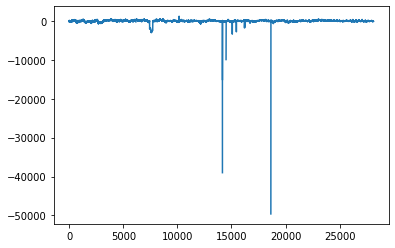

In [551]:

correced_y = hample_filter(df_validation["y"].copy(deep=True).values, window_size=12*24, sigma=4)
plt.plot(correced_y, label="Filtered")
plt.show()


In [462]:
df_validation.y[df_validation.y < df.y.min()].count()

304

Threshold: 818.722. Removed spiky data. Percent removed: 2.3684% 


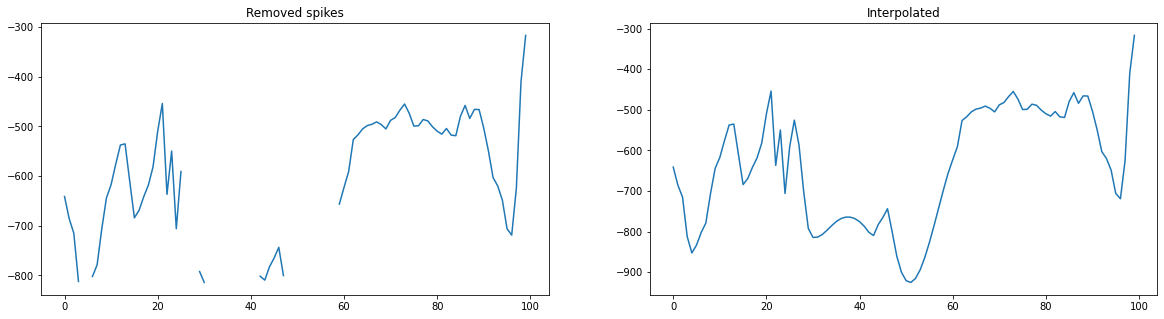

In [369]:
def clean_target_data(df, visualise=True):
	threshold = df.y.median() + 4*df.y.mad()
	print("Threshold: %.3f. Removed spiky data. Percent removed: %.4f%% " % (threshold, 100 * df.y[np.abs(df.y.values) > threshold].count() / df.shape[0]))
	df_max = df.y.argmax()
	df_min = df.y.argmin()
	df_copy = df.copy(deep=True)
	df_copy["y"].where(np.abs(df.y.values) < threshold, np.nan, inplace=True)

	if visualise:
		fig, ax = plt.subplots(1,2, figsize=(20,5))
		critical_point = df_min if df_copy["y"][df_min] else df_max # a critical point of y data
		ax[0].plot(df_copy["y"][critical_point-50:critical_point+50].values) # The critical part of y data
		ax[0].set_title("Removed spikes")

		inter_df = df_copy["y"].interpolate(method='cubic', inplace=False)
		ax[1].plot(inter_df[critical_point-50:critical_point+50].values)
		ax[1].set_title("Interpolated")
		plt.show()

	df_copy["y"].interpolate(method='cubic', inplace=True)
	return df_copy
f = clean_target_data(df)

<AxesSubplot:ylabel='Frequency'>

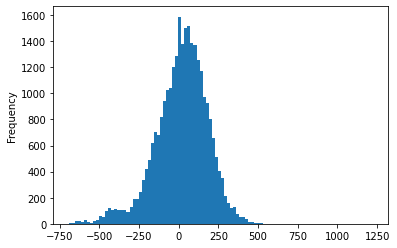

In [315]:
df_validation_copy.y.plot(kind="hist", bins=100)

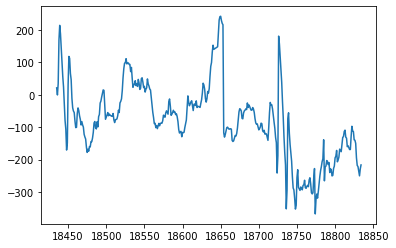

In [287]:
# Fills inn NaN values using interpolation
df_validation_copy["y"].interpolate(method='cubic', inplace=True)
plt.plot(df_validation_copy["y"][18635-200:18635+200])

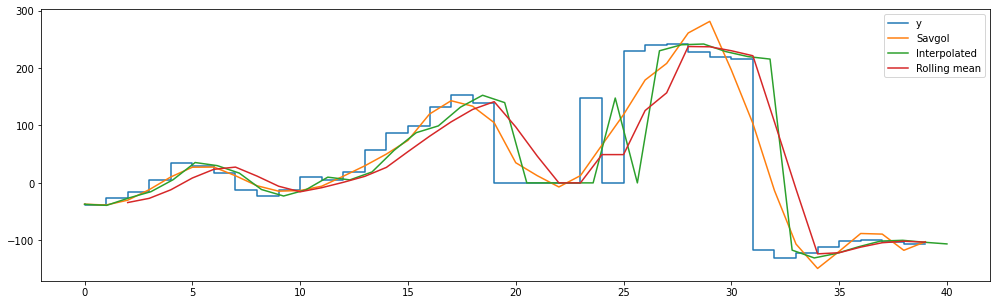

In [132]:
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
noisy_data = df_validation_copy.y[18635-20:18635+20].values
savgol_data = savgol_filter(noisy_data, window_length=11, polyorder=5)
interpolated = interp1d(np.linspace(0, len(noisy_data), len(noisy_data)), noisy_data, kind='linear')
rolling_mean = df_validation.y[18635-20:18635+20].rolling(window=3).mean()

plt.figure(figsize=(17,5))
plt.step(np.arange(len(noisy_data)), noisy_data, label='y')
plt.plot(savgol_data, label='Savgol')
plt.plot(np.linspace(0, len(noisy_data), len(noisy_data)), interpolated.y, label='Interpolated')
plt.plot(rolling_mean.values, label='Rolling mean')
plt.legend()



## Feature engineering

In [613]:
def add_time_features(df):
	# converts time, which is periodically, as a sine/cosine wave with equal periods
	df['start_time'] = pd.to_datetime(df['start_time'])
	df['Minute sine'] = np.sin(2*np.pi*df['start_time'].dt.minute/60)
	df['Minute cosine'] = np.cos(2*np.pi*df['start_time'].dt.minute/60)
	df['Hour sine'] = np.sin(2*np.pi*df['start_time'].dt.hour/(24))
	df['Hour cosine'] = np.cos(2*np.pi*df['start_time'].dt.hour/24)
	df['Day sine'] = np.sin(2*np.pi*df['start_time'].dt.day/365.2524)
	df['Day cosine'] = np.cos(2*np.pi*df['start_time'].dt.day/365.2524)
	df['Month sine'] = np.sin(2*np.pi*df['start_time'].dt.month/12)
	df['Month cosine'] = np.cos(2*np.pi*df['start_time'].dt.month/12)
	df['Week sine'] = np.sin(2*np.pi*df['start_time'].dt.isocalendar().week/52)
	df['Week cosine'] = np.cos(2*np.pi*df['start_time'].dt.isocalendar().week/52)
	#df['Year sine'] = np.sin(2*np.pi*df['start_time'].dt.year/365.2524)
	#df['Year cosine'] = np.cos(2*np.pi*df['start_time'].dt.year/365.2524)
	return df

def add_lag_features(df, lag):
	#df['flow_lag_'+str(lag)] = df['flow'].shift(lag)
	df['prev_y_'+str(lag)] = df['y'].shift(lag)
	df.dropna(inplace=True)
	return df

In [618]:
# start time and river dropped
column_indcies = ['hydro', 'micro', 'thermal', 'wind', 'total',
        'sys_reg', 'flow', 'Minute sine', 'Minute cosine', 'Hour sine',
       'Hour cosine', 'Day sine', 'Day cosine', 'Month sine', 'Month cosine',
       'Week sine', 'Week cosine', 'prev_y_1', 'y'] ## MAKE SURE Y IS IN THE LAST COLUMN

In [619]:
train_df = add_time_features(df)
train_df = add_lag_features(df, 1)[column_indcies]

test_df = add_time_features(df_validation)
test_df = add_lag_features(df_validation, 1)[column_indcies]

In [621]:
train_df.head()

,hydro,micro,thermal,wind,total,sys_reg,flow,Minute sine,Minute cosine,Hour sine,Hour cosine,Day sine,Day cosine,Month sine,Month cosine,Week sine,Week cosine,prev_y_1,y
3,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,5.000000e-01,-8.660254e-01,-0.5,-0.866025,0.154203,0.988039,0.5,0.866025,0.239316,0.970942,323.877221,296.438463
4,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,5.665539e-16,-1.000000e+00,-0.5,-0.866025,0.154203,0.988039,0.5,0.866025,0.239316,0.970942,296.438463,269.097132
5,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,-5.000000e-01,-8.660254e-01,-0.5,-0.866025,0.154203,0.988039,0.5,0.866025,0.239316,0.970942,269.097132,232.113498
6,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,-8.660254e-01,-5.000000e-01,-0.5,-0.866025,0.154203,0.988039,0.5,0.866025,0.239316,0.970942,232.113498,219.726446
7,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,-1.000000e+00,-1.836970e-16,-0.5,-0.866025,0.154203,0.988039,0.5,0.866025,0.239316,0.970942,219.726446,177.457570


Text(0.5, 1.0, 'Hour sine')

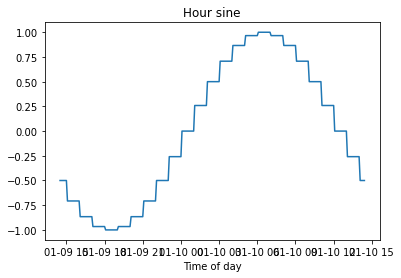

In [622]:
#train_df["Minute cosine"][:12].plot()
#plt.plot(train_df['start_time'][:12*24].values, train_df["Minute cosine"][:12*24])
plt.plot(pd.to_datetime(df['start_time'])[1:12*24+1].values, train_df["Hour sine"][:12*24])
plt.xlabel('Time of day')
plt.title("Hour sine")

<AxesSubplot:>

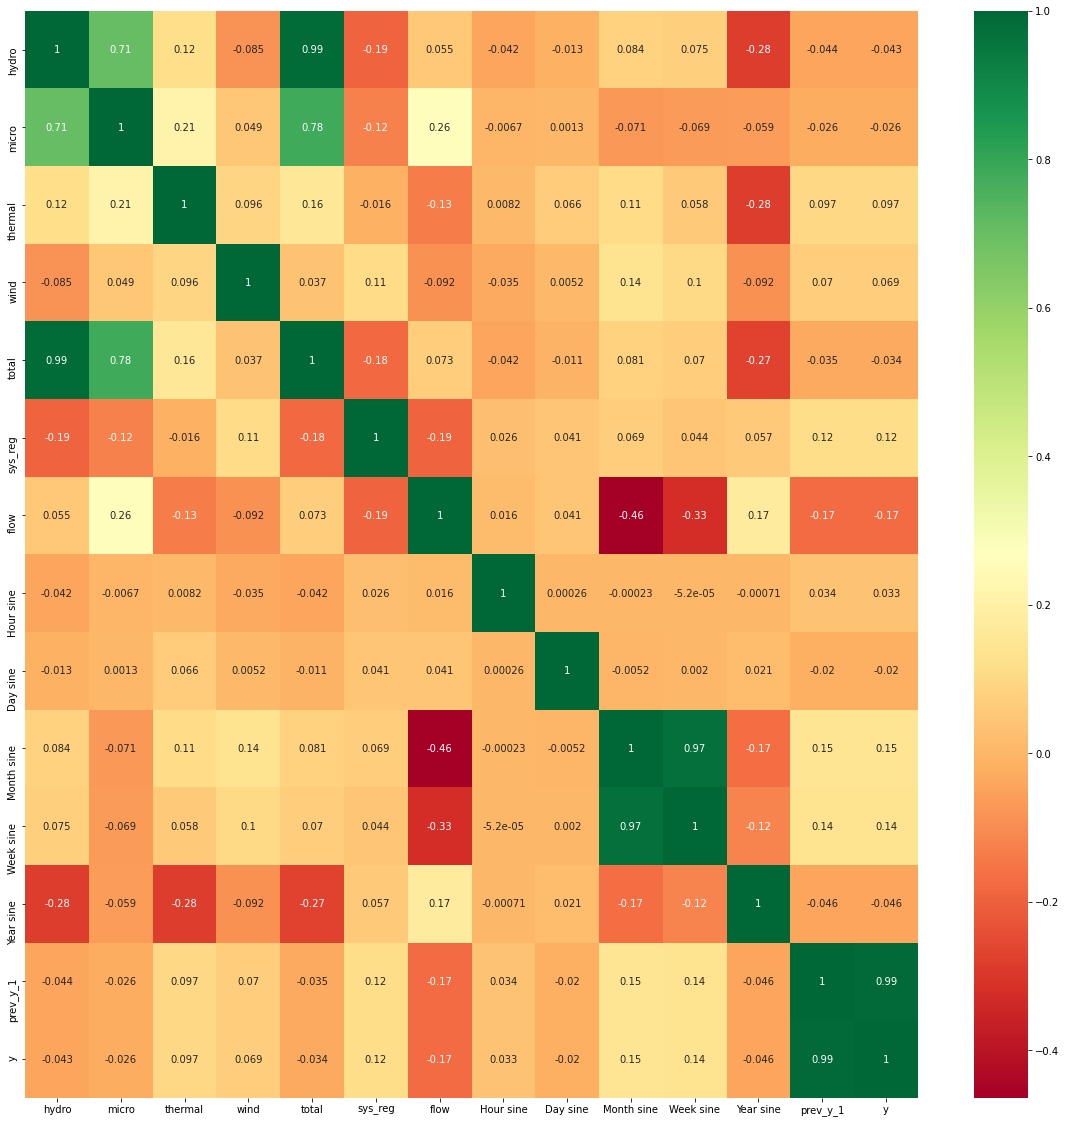

In [600]:
import seaborn as sns
plt.figure(figsize=(20,20))
sns.heatmap(train_df.corr(), annot=True, cmap='RdYlGn')


#### Structural imbalance

In [695]:
import scipy as sc
shifted = train_df.loc[:, "total"].shift(1)
shifted.iloc[0] = shifted.iloc[1] # dirichlet boundary condition
train_df["total_shifted"] = ((train_df.loc[:, "total"] + shifted)/2)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


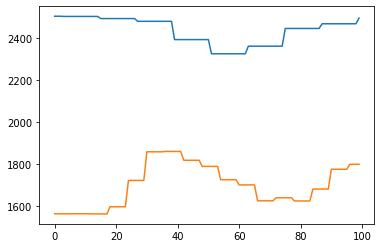

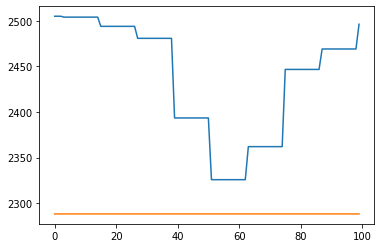

In [742]:
x = np.linspace(0, len(train_df), len(train_df))
spl = sc.interpolate.splrep(x, train_df["total"].values)
f = sc.interpolate.splev(np.linspace(0, len(train_df), 10000000), spl)

plt.plot(train_df["total"].values[10000:10000+ 100])
plt.plot(f[10000:10000+ 100])

TypeError: __call__() takes 2 positional arguments but 3 were given

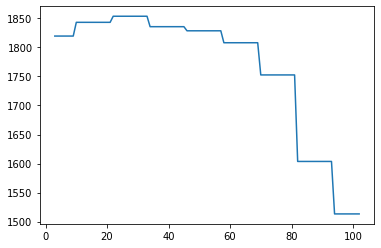

In [685]:
import scipy as sp
plt.plot(train_df.total[:100], label="original")
plt.plot(np.linspace(0, len(train_df.total_shifted), len(train_df.total_shifted))[:100], interpolated(np.linspace(0, len(train_df.total_shifted), len(train_df.total_shifted)), "cubic")[:100])

## TRANING AND TESTING

In [582]:
from tqdm import tqdm
from functions import WindowGenerator

In [580]:
train_df = add_time_features(df)[column_indcies]
test_df = add_time_features(df_validation)[column_indcies]

generator = WindowGenerator(train_data=train_df, test_data=test_df, validation_data=None, target="y",
							n_input=12*24, n_output=1, shift=1, num_predictions=12*4)
train_data = generator.getTrainData()

(None, 288, 18) (None, 1)


In [497]:
input_shape = generator.getInputShape()

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64, input_shape=input_shape, return_sequences=False))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.LSTM(units=128, input_shape=input_shape, return_sequences=False))
model.add(tf.keras.layers.Dense(units=1))


model.compile(loss=tf.losses.MeanSquaredError(), optimizer='adam', metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_data, epochs=2, verbose=1, shuffle=False) # , validation_data=(test_X, test_y)

Epoch 1/2
   5/7025 [..............................] - ETA: 20:57 - loss: 0.3278 - mean_absolute_error: 0.4916

KeyboardInterrupt: 

  0%|          | 0/47 [00:00<?, ?it/s]

(None, 288, 18) (None, 1)


100%|██████████| 47/47 [00:04<00:00, 10.70it/s]


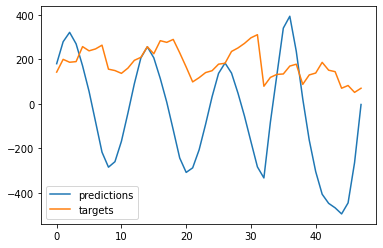

In [542]:
generator.predict_and_plot(model, test_df, start_pos=200)

In [503]:
#model.save_weights("ltsm_64_1_30k_data_10_epochs_uncleaned")
model.load_weights("model_weights/ltsm_64_1_30k_data_10_epochs_uncleaned")

## Testing

(None, 5, 18) (None, 1)
(None, 5, 18) (None, 1)
(None, 5, 18) (None, 1)


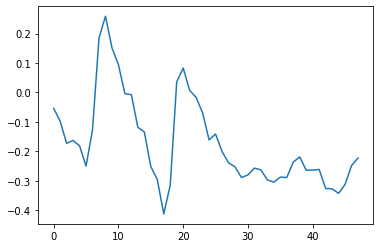

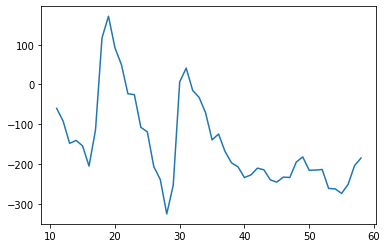

In [573]:
train_df = add_time_features(df)[column_indcies]
test_df = add_time_features(df_validation)[column_indcies]

generator = WindowGenerator(train_data=train_df, test_data=test_df, validation_data=None, target="y",
							n_input=5, n_output=1, shift=1, num_predictions=12*4)
train_data = generator.getTrainData()
testing_data = generator.getTestData()
generator.testing(testing_data)

In [574]:
list(train_data.take(1))[0]

(<tf.Tensor: shape=(3, 5, 18), dtype=float64, numpy=
 array([[[-7.39398045e-01, -1.40477875e+00, -2.87887622e+00,
           3.97953531e-01, -8.33957538e-01,  4.17947262e-01,
          -1.84375532e+00,  7.07104425e-01, -1.22473807e+00,
          -7.06658747e-01, -1.22507563e+00, -7.73954701e-01,
           8.65079549e-01,  6.49179957e-01,  1.16885550e+00,
           2.93004100e-01,  1.28193122e+00,  9.83482427e-01],
         [-7.39398045e-01, -1.40477875e+00, -2.87887622e+00,
           3.97953531e-01, -8.33957538e-01,  4.17947262e-01,
          -1.84375532e+00, -3.14151350e-06, -1.41420655e+00,
          -7.06658747e-01, -1.22507563e+00, -7.73954701e-01,
           8.65079549e-01,  6.49179957e-01,  1.16885550e+00,
           2.93004100e-01,  1.28193122e+00,  8.97806576e-01],
         [-7.39398045e-01, -1.40477875e+00, -2.87887622e+00,
           3.97953531e-01, -8.33957538e-01,  4.17947262e-01,
          -1.84375532e+00, -7.07110708e-01, -1.22473807e+00,
          -7.06658747e-01, -1.

In [576]:
generator.normalize(train_df).y.values[5:20]

array([0.47065292, 0.46007679, 0.65804638, 0.71811973, 0.71534087,
       0.64198682, 0.65296995, 0.58532708, 0.56695394, 0.52539521,
       0.49331103, 0.4694826 , 0.45081189, 0.32007143, 0.37162014])

In [577]:
forecasting_num = 12*2
data = generator.getTestData()
first_data = list(data.take(forecasting_num))[0]

sequences = first_data[0].numpy()[:10]
targets = first_data[1]
sequences.shape, targets.shape

(None, 5, 18) (None, 1)


((10, 5, 18), TensorShape([48, 1]))

In [578]:
sequence = tf.expand_dims(sequences[0], axis=0)
print(sequence.shape)
prediction = model.predict(sequence)[0][0]


for sequence in sequences[1:]:
	sequence[-1, -1] = prediction
	print(sequence[-4:, -1])
	sequence = tf.expand_dims(sequence, axis=0)
	prediction = model.predict(sequence)[0][0]

(1, 5, 18)


ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 288, 18), found shape=(None, 5, 18)


In [928]:
train_data = add_time_features(df)[column_indcies]
test_data = add_time_features(df_validation)[column_indcies]
target_col = "y"

In [935]:
def makeData(data):

	x_data = np.array(data.values, dtype=np.float32)
	batchIterator = tf.keras.utils.timeseries_dataset_from_array(data=x_data, targets=None, sequence_length=12*24+1, batch_size=1, shuffle=False)
	return batchIterator

In [936]:
def split_window(dataObj):
	n_input = 12*24

	n_output = 1
	samples = dataObj[:, slice(0, n_input), slice(0, col_indexes["y"])]
	labels = dataObj[:, slice(n_input, None) , :]

	labels = labels[:, :, col_indexes["y"]]

	samples.set_shape([None, n_input, None])
	#labels = tf.squeeze(labels)
	labels.set_shape([None, 1])

	print(samples.shape, labels.shape)
	return samples, labels

In [941]:
col_indexes = {col: i for i, col in enumerate(train_data.columns)}
d = makeData(train_data)
t = d.map(split_window)

sample = list(t.take(4))
sample

(None, 288, 18) (None, 1)


[(<tf.Tensor: shape=(1, 288, 18), dtype=float32, numpy=
  array([[[ 1.5918390e+03,  1.4192799e+02,  1.1500000e+01, ...,
           -1.7307046e-01, -9.8490947e-01,  3.4133002e+02],
          [ 1.5918390e+03,  1.4192799e+02,  1.1500000e+01, ...,
           -1.7307046e-01, -9.8490947e-01,  3.3011432e+02],
          [ 1.5918390e+03,  1.4192799e+02,  1.1500000e+01, ...,
           -1.7307046e-01, -9.8490947e-01,  3.2387723e+02],
          ...,
          [ 2.0603340e+03,  1.3845799e+02,  1.1500000e+01, ...,
           -1.7307046e-01, -9.8490947e-01,  3.6317267e+02],
          [ 2.0603340e+03,  1.3845799e+02,  1.1500000e+01, ...,
           -1.7307046e-01, -9.8490947e-01,  3.7202802e+02],
          [ 2.0603340e+03,  1.3845799e+02,  1.1500000e+01, ...,
           -1.7307046e-01, -9.8490947e-01,  3.7637405e+02]]], dtype=float32)>,
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[368.56143]], dtype=float32)>),
 (<tf.Tensor: shape=(1, 288, 18), dtype=float32, numpy=
  array([[[ 1.5918390e

3         0.897812
4         0.812440
5         0.696961
6         0.658283
7         0.526301
            ...   
225083    0.414396
225084    0.375131
225085    0.268543
225086    0.292528
225087    0.202726
Name: y, Length: 225085, dtype: float64

In [871]:
sample[0].shape, sample[1].shape
train_df.iloc[12*24:]["y"]

289       368.561429
290       364.915513
291       337.967473
292       326.137265
293       291.972908
             ...    
225083    141.618915
225084    129.043820
225085     94.907548
225086    102.589040
225087     73.829019
Name: y, Length: 224799, dtype: float64

In [872]:
input_shape = generator.getInputShape()
print(input_shape)
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=128, input_shape=input_shape, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=128, input_shape=input_shape, return_sequences=False))
model.add(tf.keras.layers.Dense(units=1))


model.compile(loss=tf.losses.MeanSquaredError(), optimizer='adam', metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(t, epochs=2, verbose=1, shuffle=False) # , validation_data=(test_X, test_y)

(288, 18)
Epoch 1/2
  13/7025 [..............................] - ETA: 44:19 - loss: 32538.3789 - mean_absolute_error: 135.3089

KeyboardInterrupt: 